# Predictive Analysis

#### Importing Libraries

In [1]:
#Libraries for Wrangling
import pandas as pd
import numpy as np

#Libraries for Excel operations
import xlrd
import openpyxl

#Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

#Libraries for building and Validating model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#### Importing Dataset

In [2]:
raw_data = pd.read_excel('ANZ synthesised transaction dataset.xlsx')

In [3]:
#Summarising Dataset
raw_data.head()
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

#### Wrangling Dataset

##### Creating dataframe1

In [4]:
df = raw_data

In [5]:
df_salary = df[(df.txn_description == "PAY/SALARY") & (df.movement == "credit")]

In [6]:
df_salary = df_salary.groupby('customer_id').agg({
    ##'age':'mean',
    'amount':'mean',
    'transaction_id':'count'
})

In [7]:
df_salary['salary_type'] = df_salary['transaction_id'].apply(lambda x: 'Weekly' if x > 10 else 'Fortnite' )

In [8]:
df_salary['annual_salary_cal'] = df_salary['salary_type'].apply(lambda x: 52 if x =="Weekly" else 26 )

In [9]:
df_salary['annual_salary'] = df_salary['annual_salary_cal'] * df_salary['amount']

In [10]:
df_salary = df_salary.drop(['annual_salary_cal','transaction_id'], axis =1)

In [11]:
df_salary['salary_code'] = df_salary['salary_type'].apply(lambda x: 0 if x =="Weekly" else 1)

In [12]:
df_salary

,amount,salary_type,annual_salary,salary_code
customer_id,,,,
CUS-1005756958,970.47,Weekly,50464.44,0
CUS-1117979751,3578.65,Fortnite,93044.90,1
CUS-1140341822,1916.51,Fortnite,49829.26,1
CUS-1147642491,1711.39,Weekly,88992.28,0
CUS-1196156254,3903.73,Fortnite,101496.98,1
...,...,...,...,...
CUS-72755508,725.32,Weekly,37716.64,0
CUS-809013380,1037.07,Weekly,53927.64,0
CUS-860700529,1808.62,Fortnite,47024.12,1


##### Creating dataframe2

In [13]:
df_ag = df.groupby('customer_id').agg({
    'age':'mean',
    'gender':'max'
})

In [14]:
df_ag

,age,gender
customer_id,,
CUS-1005756958,53,F
CUS-1117979751,21,M
CUS-1140341822,28,M
CUS-1147642491,34,F
CUS-1196156254,34,F
...,...,...
CUS-72755508,35,F
CUS-809013380,21,F
CUS-860700529,30,M


##### Creating dataframe3

In [15]:
df_trans = df[(df.movement == "debit") & (df.txn_description != "PAY/SALARY")]

In [16]:
df_trans = df_trans.groupby(['customer_id','date']).agg({
    'transaction_id':'count',
    'amount':'sum',
    'balance':'mean'
})

In [17]:
#df_trans.head(34)

In [18]:
df_trans = df_trans.groupby('customer_id').agg({
    'transaction_id':'mean',
    'amount':'mean',
    'balance':'mean'
})

##### Merging all dataframes

In [19]:
df_new = pd.merge(df_trans,df_ag, on='customer_id', how = 'inner')
df_new = pd.merge(df_new,df_salary, on='customer_id', how = 'inner')
df_new = df_new.reset_index()

In [20]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     100 non-null    object 
 1   transaction_id  100 non-null    float64
 2   amount_x        100 non-null    float64
 3   balance         100 non-null    float64
 4   age             100 non-null    int64  
 5   gender          100 non-null    object 
 6   amount_y        100 non-null    float64
 7   salary_type     100 non-null    object 
 8   annual_salary   100 non-null    float64
 9   salary_code     100 non-null    int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 6.7+ KB


In [21]:
df_new = df_new.rename( columns = {
    'customer_id':'Customer_ID',
    'transaction_id':'Avg.Transaction/Day',
    'amount_x':'Avg.Spending/Day',
    'balance':'Avg.Balance/Day',
    'age':'Age',
    'gender':'Gender',
    'amount_y':'Salary',
    'salary_type':'SalaryType',
    'annual_salary':'AnnualSalary',
    'salary_code':'SalaryCode'
})

In [22]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_ID          100 non-null    object 
 1   Avg.Transaction/Day  100 non-null    float64
 2   Avg.Spending/Day     100 non-null    float64
 3   Avg.Balance/Day      100 non-null    float64
 4   Age                  100 non-null    int64  
 5   Gender               100 non-null    object 
 6   Salary               100 non-null    float64
 7   SalaryType           100 non-null    object 
 8   AnnualSalary         100 non-null    float64
 9   SalaryCode           100 non-null    int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 6.7+ KB


In [23]:
df_1 = df_new
df_1['GenderCode'] = df_1['Gender'].apply(lambda x: 0 if x == "M" else 1)

In [24]:
# Exporting the Wrangled Dataset
df_1.to_excel(r'WrangledANZdata.xlsx', index = False)

In [25]:
df_1

,Customer_ID,Avg.Transaction/Day,Avg.Spending/Day,Avg.Balance/Day,Age,Gender,Salary,SalaryType,AnnualSalary,SalaryCode,GenderCode
0,CUS-1005756958,1.764706,107.437059,2280.518333,53,F,970.47,Weekly,50464.44,0,1
1,CUS-1117979751,1.550000,148.897000,9906.595539,21,M,3578.65,Fortnite,93044.90,1,0
2,CUS-1140341822,1.897436,141.321538,5376.821966,28,M,1916.51,Fortnite,49829.26,1,0
3,CUS-1147642491,1.944444,124.680556,8949.697895,34,F,1711.39,Weekly,88992.28,0,1
4,CUS-1196156254,3.090909,113.306623,22143.115248,34,F,3903.73,Fortnite,101496.98,1,1
...,...,...,...,...,...,...,...,...,...,...,...
95,CUS-72755508,1.277778,75.959167,4388.692037,35,F,725.32,Weekly,37716.64,0,1
96,CUS-809013380,2.581395,123.911163,4094.616089,21,F,1037.07,Weekly,53927.64,0,1
97,CUS-860700529,3.439394,109.820606,3330.810259,30,M,1808.62,Fortnite,47024.12,1,0
98,CUS-880898248,1.800000,71.464250,8530.379646,26,M,1433.98,Fortnite,37283.48,1,0


## Exploratory Data Analysis

#### Correlation

In [26]:
df_2 = df_1[['Age','AnnualSalary']]

In [27]:
np.corrcoef(df_2['Age'],df_2['AnnualSalary'])

array([[ 1.        , -0.07255845],
       [-0.07255845,  1.        ]])

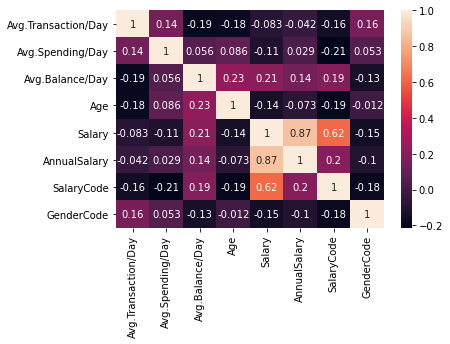

In [28]:
#Plot to show the correlation between all variables
sns.heatmap(df_1.corr(), annot=True)
plt.show()

The correlation plot suggests that most of the dependent variables are not associated with the independent variable.
Let us plot some visualization to analysis further.

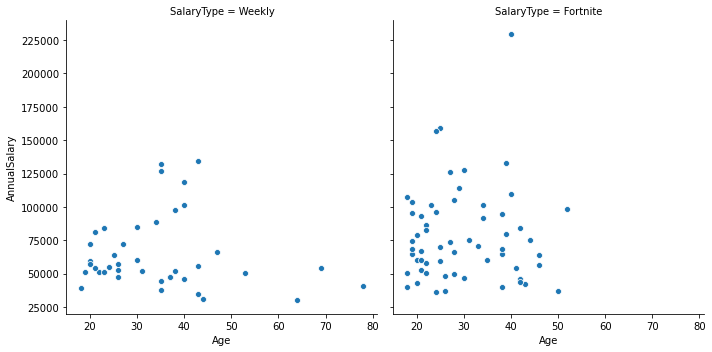

In [29]:
#Plot to show relation between Age and Annual Salary by SalaryType
sns.relplot(
    data=df_1, x="Age", y="AnnualSalary",
    col="SalaryType",
    kind="scatter"
)

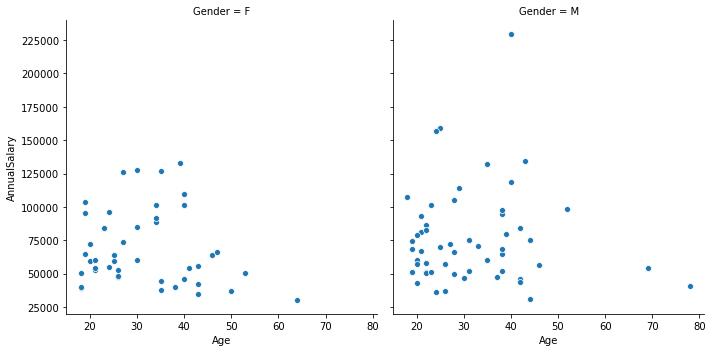

In [30]:
#Plot to show relation between Age and Annual Salary by Gender
sns.relplot(
    data=df_1, x="Age", y="AnnualSalary",
    col="Gender", #hue="day", style="day",
    kind="scatter"
)

In [31]:
df_1.info()
df_3 = df_1
df_3['Age'] = df_1['Age'].astype(float)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_ID          100 non-null    object 
 1   Avg.Transaction/Day  100 non-null    float64
 2   Avg.Spending/Day     100 non-null    float64
 3   Avg.Balance/Day      100 non-null    float64
 4   Age                  100 non-null    int64  
 5   Gender               100 non-null    object 
 6   Salary               100 non-null    float64
 7   SalaryType           100 non-null    object 
 8   AnnualSalary         100 non-null    float64
 9   SalaryCode           100 non-null    int64  
 10  GenderCode           100 non-null    int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 7.5+ KB


In [32]:
#Finding the Slope and Intercept
linregress(df_3['Age'],df_3['AnnualSalary'])

LinregressResult(slope=-206.42485566228154, intercept=79226.58886439068, rvalue=-0.07255844686502286, pvalue=0.473122095472985, stderr=286.6254388064871)

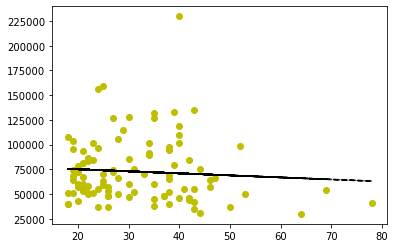

In [33]:
#Scatter plot between Age and Annual Salary
coef = np.polyfit(df_3['Age'],df_3['AnnualSalary'],1)
poly1d_fn = np.poly1d(coef) 

plt.plot(df_3['Age'],df_3['AnnualSalary'], 'yo', df_3['Age'], poly1d_fn(df_3['Age']), '--k')

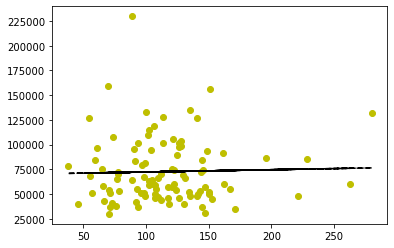

In [34]:
#Scatter plot between Avg.Spending/Day and Annual Salary
coef = np.polyfit(df_3['Avg.Spending/Day'],df_3['AnnualSalary'],1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(df_3['Avg.Spending/Day'],df_3['AnnualSalary'], 'yo', df_3['Avg.Spending/Day'], poly1d_fn(df_3['Avg.Spending/Day']), '--k')

Here, we could see none of the variables have a good positive relationship with the independent variable.

## Regression Model

In [35]:
#Building a regression model to predict the annual salary for each customer using the attributes you identified above

In [36]:
x = pd.DataFrame(df_3['Age'])
y = pd.DataFrame(df_3['AnnualSalary'])

In [37]:
model_lm = LinearRegression().fit(x,y.values.reshape((-1,1)))

##### Evaluating Regression model

In [38]:
print('R-Squared value = ',model_lm.score(x,y))

R-Squared value =  0.005264728211464176


Here, we have a very poor RSquare value, which suggests that model is a poor fit.

<b>Therefore, we cannot use this model to segment customers into income brackets for reporting purposes</b>

## Decision Tree

In [39]:
#Since Regression performs poorly, let us try building a decision tree model to predicy salary.

In [40]:
x1 = df_3[['Avg.Transaction/Day','Avg.Spending/Day','Avg.Balance/Day','Age','GenderCode','Salary','SalaryCode']]
y1 = df_3[['AnnualSalary']]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.3, random_state=1)

In [42]:
dtreg = DecisionTreeRegressor()

In [43]:
dtreg = dtreg.fit(X_train,y_train)

##### Evaluating Decision Tree model

In [44]:
print('R-Squared value = ',dtreg.score(x1,y1))

R-Squared value =  0.8850607199998896


<b>Here, we get a accuracy of 93% which is a very good model. </b>

##### Predicting Salary using Decision Tree model

In [47]:
y_pred = dtreg.predict(X_test)

In [48]:
y_pred

array([ 45703.32,  93044.9 ,  88992.28,  68633.76,  72565.48,  75070.84,
        51508.6 ,  60327.8 ,  37716.64,  72565.48,  68831.88,  45703.32,
       127048.48,  47671.  ,  47707.4 , 101221.64,  60327.8 , 127683.4 ,
        45703.32,  96526.56,  50153.22, 109617.04,  45703.32, 101221.64,
        84012.76,  79849.64,  52615.68, 127683.4 ,  51508.6 , 156636.74])

This predicted values are similar to the actual values.

<b>Let us visualize that using the below plot.</b>

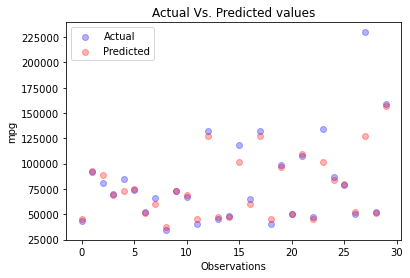

In [49]:
_, ax = plt.subplots()

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual Vs. Predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

#### Cross validating the Decision Tree Model

In [51]:
scores = cross_val_score(dtreg, x1, y1, cv=10)
scores

array([0.96858716, 0.98537802, 0.65803729, 0.52294669, 0.97023759,
       0.99096639, 0.91453754, 0.97247554, 0.97572702, 0.98678515])

We can see all the values have a good score.
<b>Thus, I conclude, the Decision Tree model can be used to predict the salary of the customers with the identified attributes.</b>